# Plot of calibration results for the publication

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from os.path import join
import calibration_functions as cf

In [2]:
# number of days used to compare the simulated and empirical data and
# calculate the error metric. This value is chosen to be the duration
# (in days) of the longest of the observed outbreaks.
comp_period = 27

## Load empirical data

In [3]:
emp_data_src = '../data/outbreaks'
emp_data = pd.DataFrame()

# sequentially load data from all four outbreaks. The maximum duration of an
# oubtreak is 27 days, the other outbreaks are shorter. We therefore "pad" the
# data for the shorter outbreaks at the end by appending the last entry of the
# cumulative number of infected employees and residents. This does not change
# the meaning of the data, as the "cumulative infected" are the sum of exposed,
# infected and recovered agents. Agents that transition from infected to 
# recovered do not change the "cumulative infected". 
for ob in range(1, 5):
    tmp = pd.read_csv(join(emp_data_src, 'outbreak_{}.csv'.format(ob)))
    tmp['outbreak'] = ob
    if len(tmp) < comp_period:
        for i in range(0, comp_period - len(tmp) + 1):
            tmp = tmp.append(tmp.loc[tmp.index[-1]], ignore_index=True)
            tmp['t'] = range(len(tmp))
    emp_data = pd.concat([emp_data, tmp])
emp_data = emp_data.reset_index()

emp_data['resident_ratio'] = emp_data['cumulative_I_resident'] / \
(emp_data['cumulative_I_resident'] + emp_data['cumulative_I_employee'])
emp_data['cumulative_I_total'] = emp_data['cumulative_I_resident'] +\
    emp_data['cumulative_I_employee']

## Load parameter scan results

In [4]:
dst = '../data/calibration_results'
N_runs_coarse = 1000
N_runs_fine = 5000

results1 = pd.read_csv(join(dst,'calibration_results_fine_N{}.csv'.format(N_runs_fine)))
results2 = pd.read_csv(join(dst,'calibration_results_coarse_N{}.csv'.format(N_runs_coarse)))
results = pd.concat([results1, results2])
results = results.sort_values(by='contact_weight')
results = results.reset_index(drop=True)

results['infected_employee_distance_total_mean'] = \
    results[['infected_employee_distance_outbreak_{}_mean'.format(i) for i in range(1, 5)]].mean(axis=1)
results['infected_employee_distance_total_std'] = \
    results[['infected_employee_distance_outbreak_{}_mean'.format(i) for i in range(1, 5)]].std(axis=1)

results['infected_resident_distance_total_mean'] = \
    results[['infected_resident_distance_outbreak_{}_mean'.format(i) for i in range(1, 5)]].mean(axis=1)
results['infected_resident_distance_total_std'] = \
    results[['infected_resident_distance_outbreak_{}_mean'.format(i) for i in range(1, 5)]].std(axis=1)

results['distance_total'] = results['infected_employee_distance_total_mean'] +\
                            results['infected_resident_distance_total_mean']
results['distance_total_std'] = np.sqrt(results['infected_employee_distance_total_std']**2 + \
                                        results['infected_resident_distance_total_std'] **2)

best_weight = results.loc[\
    results['distance_total'].idxmin()]['contact_weight']

print('best contact weight: {}'.format(best_weight))

best contact weight: 0.16


In [7]:
results = results.set_index(['contact_weight'])

## Load ensemble results of the optimal contact weight

In [8]:
sim_data_src = '../data/calibration_results/ensembles'
sim_data = pd.read_csv(join(sim_data_src, 'cw-{:1.3f}.csv'.format(best_weight)))

sim_data['I_total_employee'] = sim_data['E_employee'] +\
            sim_data['I_employee'] + sim_data['R_employee']
sim_data['I_total_resident'] = sim_data['E_resident'] +\
            sim_data['I_resident'] + sim_data['R_resident']
sim_data['I_total_agent'] = sim_data['I_total_employee'] +\
            sim_data['I_total_resident']
sim_data['I_resident_ratio'] = sim_data['I_total_resident'] / \
    (sim_data['I_total_resident'] + sim_data['I_total_employee'])

agg = sim_data[['I_total_employee', 'I_total_resident', 'I_total_agent',
                'I_resident_ratio', 'step']]\
    .groupby('step')\
    .agg({'I_total_employee':['mean', 'std'],
          'I_total_resident':['mean', 'std'],
          'I_total_agent':['mean', 'std'],
          'I_resident_ratio':['mean', 'std']})

## Plots

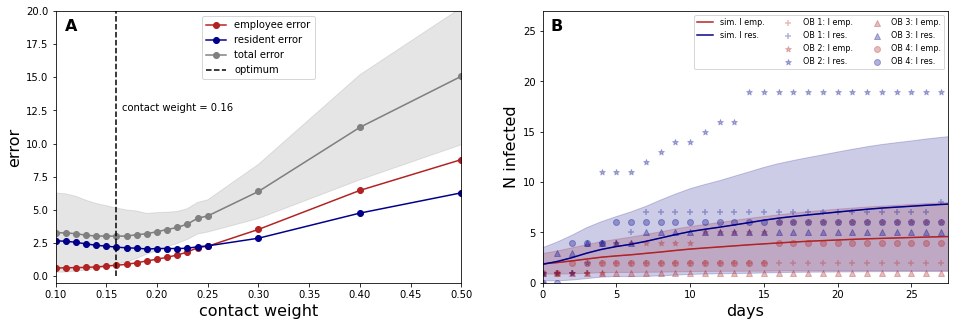

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))
cf.plot_errors(axes[0], results, best_weight)
cf.plot_emp_sim_data(axes[1], emp_data, agg, comp_period)

fig.text(0.133, 0.825, 'A', fontsize=16, fontweight='bold')
fig.text(0.555, 0.825, 'B', fontsize=16, fontweight='bold')

plt.savefig('../plots/outbreak_sizes_sim_emp.pdf')
plt.savefig('../plots/outbreak_sizes_sim_emp.png', dpi=300)
plt.savefig('../plots/outbreak_sizes_sim_emp.svg')